In [1]:
import pandas as pd
import numpy as np
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator
import random

import perturbations

import torch

from tqdm import tqdm

%matplotlib inline

/home/ubuntu/venvs/pnma/lib/python3.10/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [14]:
from string import ascii_letters
ascii_letters += " "


class PrependPerturbation(perturbations.Perturbation):
    def __init__(self, length, alphabet=ascii_letters):
        self.alphabet=alphabet
        self.length=length

        self.appendix = " "
        for i in range(self.length):
            self.appendix+=random.choice(self.alphabet)
        

    def perturb(self, string, new_appendix=True):
        self._check_string(string)

        if self.length== 0:
            return string

        if new_appendix:

            self.appendix = ""
            for i in range(self.length):
                self.appendix+=random.choice(self.alphabet)
    
        return f'{self.appendix} {string}'

        

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main",
                                            output_hidden_states=True)

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
model.to("cuda")

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (rotary_emb): LlamaRotaryEmbedding()
          (k_proj): QuantLinear()
          (o_proj): QuantLinear()
          (q_proj): QuantLinear()
          (v_proj): QuantLinear()
        )
        (mlp): LlamaMLP(
          (act_fn): SiLUActivation()
          (down_proj): QuantLinear()
          (gate_proj): QuantLinear()
          (up_proj): QuantLinear()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Linear(in_features=4096, out_features=32000, bias=False)
)

In [4]:
instructions = "Answer only with 'yes' or 'no'. Other answers will be discarded."
prompt = "Was RA Fisher a great man?"

prompt_template = f'''<s>[INST] <<SYS>>
{instructions}
<</SYS>>

{prompt} [/INST]
'''

input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
output = model.generate(inputs=input_ids, temperature=0.9, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=3)
print(tokenizer.decode(output[0]))

/home/ubuntu/venvs/pnma/lib/python3.10/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


<s><s>[INST] <<SYS>>
Answer only with 'yes' or 'no'. Other answers will be discarded.
<</SYS>>

Was RA Fisher a great man? [/INST]
Yes</s>


In [5]:
fisher_data_file_path = '/home/ubuntu/pnma/files/RA-Fisher.csv'
fisher_data = pd.read_csv(fisher_data_file_path)
strings = fisher_data['string']
labels = fisher_data['label']
C = np.array([0 if ell=='statistics' else 1 for ell in labels])

In [15]:
np.random.seed(1)

perturbations_dict = {}
length_list = [0, 1000]
n_perturbations=1


for i, p in enumerate(tqdm(length_list)):    
    perturbations_dict[p] = {}
    perturber = PrependPerturbation(p)
    for s in strings:
        if p == 0:
            perturbations_dict[p][s] = [perturber.perturb(s, new_appendix=False)]
        else:
            perturbations_dict[p][s] = [perturber.perturb(s, new_appendix=False) for _ in range(n_perturbations)]

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2057.04it/s]


In [16]:
def get_response(model, input_ids, tokenizer, generate_kwargs={'max_new_tokens': 3}):    
    output = model.generate(inputs=input_ids, **generate_kwargs)
    response = tokenizer.decode(output[0])

    response = response.split('[/INST]')[-1]
    response = response.split('</s>')[0]
    response = response.lower()

    response = response.split(' ')[-1]
    response = response.split('.')[0]

    return response
    

def get_embedding(model, input_ids):
    output =  model(input_ids)
    embedding = np.mean(output.hidden_states[0].detach().cpu().numpy(), axis=1).flatten()
    
    return embedding


def get_formatted_prompt(prompt, context="", instruction=None):
    if instruction is None:
        instruction = "Answer only with 'yes' or 'no' in English."

    if len(context) == 0:
        context_and_prompt = prompt

    else:
        context_and_prompt = f'{context} {prompt}'

    formatted_prompt = f'''<s>[INST] <<SYS>>
        {instruction}
        <</SYS>>
        
        {context_and_prompt} [/INST]'''

    return formatted_prompt
    

def get_strings_stratified(strings, labels, n=10, S=10):
    if S > n:
        S = n
    
    unique_labels = np.unique(labels)
    
    stats_strings_indices = np.random.choice(np.where(labels==unique_labels[1])[0], S, replace=True) 
    eugenics_strings_indices = np.random.choice(np.where(labels==unique_labels[0])[0], n-S, replace=True)

    selected_strings = [strings[i] for i in stats_strings_indices] + [strings[i] for i in eugenics_strings_indices]
    random.shuffle(selected_strings)
        
    return selected_strings


def combine_strings(string_list):
    s = ""
    for s_ in string_list:
        s += " " + s_

    return s[1:]


def get_context_and_prompt(prompt, strings, labels, C=2, S=2):
    string_list = get_strings_stratified(strings, labels, C, S)
    context_string = combine_strings(string_list)

    return context_string + " " + prompt

def estimate_p(model, input_ids, tokenizer, generate_kwargs, n_responses, max_c):
    c=0
    valid_responses=0
    phat=0
    while valid_responses<n_responses and c<max_c:
        response = get_response(model, input_ids, tokenizer, generate_kwargs)

        # print(response)

        if response.encode('utf-8') in YES_LIST:
            valid_responses+=1
            phat+=1
        elif response.encode('utf-8') in NO_LIST:
            valid_responses+=1
        c+=1

    phat /= valid_responses

    return phat

In [17]:
np.random.seed(1)

NO_LIST = [b'no', b'\xe2\x9d\x8c', b'\xe2\x98\xb9', b'\xf0\x9f\x98\x90']
YES_LIST = [b'yes', b'\xf0\x9f\x98\x8a']

skip_words = ['not', 'was']
n_responses = 10

generate_kwargs = {
    'temperature':0.8, 
    'do_sample':True, 
    'top_p':0.95, 
    'top_k':40, 
    'max_new_tokens':10
}


embeddings_dict = {}
phats_dict = {}

max_c=100

for length in length_list:
    embeddings_dict[length] = {}
    phats_dict[length] = {}
    for s in tqdm(strings):
        embeddings_dict[length][s] = []
        phats_dict[length][s] = []

        if length == 0:
            formatted_prompt = get_formatted_prompt(prompt, context=s)
            
            input_ids = tokenizer(formatted_prompt, return_tensors='pt').input_ids.cuda()
            
            embeddings_dict[length][s].append(get_embedding(model, input_ids))

            phats_dict[length][s].append(estimate_p(model, input_ids, tokenizer, generate_kwargs, n_responses, max_c))

            del input_ids

            continue

            
        for perturbed_string in perturbations_dict[length][s]:
            formatted_prompt = get_formatted_prompt(prompt, context=perturbed_string)
    
            input_ids = tokenizer(formatted_prompt, return_tensors='pt').input_ids.cuda()
        
            embedding = get_embedding(model, input_ids)
            embeddings_dict[length][s].append(embedding)
        
            phat = estimate_p(model, input_ids, tokenizer, generate_kwargs, n_responses, max_c)
            phats_dict[length][s].append(phat)

            del input_ids

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [03:12<00:00,  3.85s/it]


In [18]:
import pickle

# embeddings_and_phats = {'embeddings': embeddings_dict, 'phats': phats_dict}
# pickle.dump(embeddings_and_phats, open('/home/ubuntu/data/embeddings_and_phats_with_perturbations.p', 'wb'))
# embeddings_and_phats = pickle.load(open('/home/ubuntu/data/embeddings_and_phats_with_perturbations.p', 'rb'))
# embeddings_dict = embeddings_and_phats['embeddings']
# phats_dict = embeddings_and_phats['phats']

In [19]:
cmds_embds = {}

for i, p in enumerate([0, 1000]):
    temp_embeddings = []

    # for str, embds in embeddings_dict[0].items():
    #     temp_embeddings += embds

    for str, embds in embeddings_dict[p].items():
        temp_embeddings += embds
    temp_embeddings = np.array(temp_embeddings)

    cmds = ClassicalMDS(n_components=2)
    cmds_embds[p] = cmds.fit_transform(temp_embeddings)

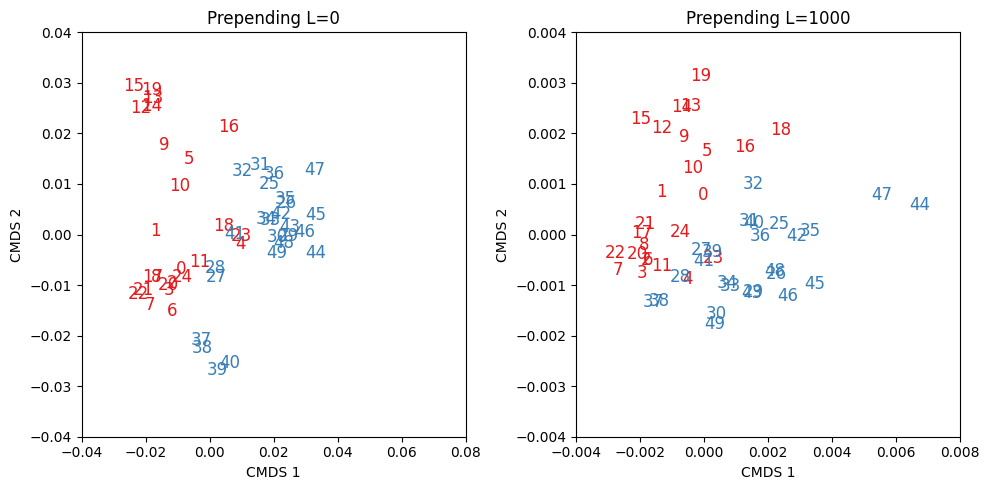

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1,2, figsize=(10,5))
p=1000

colors = sns.color_palette("Set1", n_colors=2)

for ii, p in enumerate(length_list):
    for i in range(50):
        ax[ii].text(cmds_embds[p][i, 0], cmds_embds[p][i, 1], s=i, fontsize=12, c=colors[C[i]])

    # begin = 50 + i*n_perturbations
    # end = 50 + (i+1)*n_perturbations

    # for j in range(begin, end):
    #     ax.text(cmds_embds[p][j, 0], cmds_embds[p][j, 1], s=i, fontsize=6, c=colors[C[i]], alpha=0.75)

    ax[ii].set_title(f'Prepending L={p}')
    ax[ii].set_ylabel('CMDS 2')
    ax[ii].set_xlabel('CMDS 1')

ax[0].set_xlim(-0.04, 0.08)
ax[0].set_ylim(-0.04, 0.04)

ax[1].set_xlim(-0.004, 0.008)
ax[1].set_ylim(-0.004, 0.004)

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


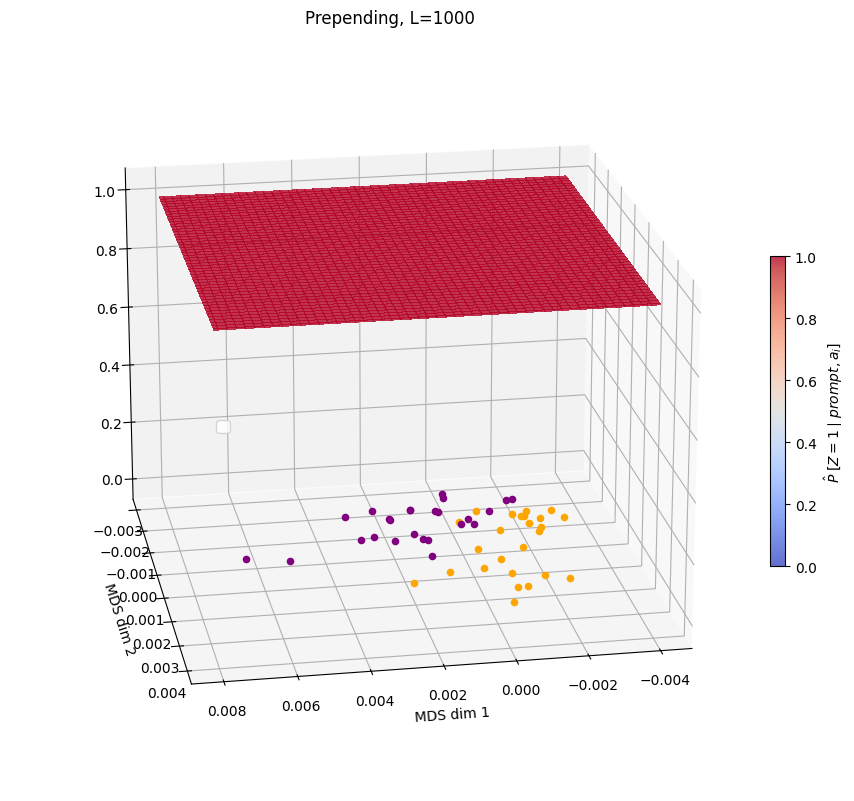

In [24]:
p=1000

phats = []
ells = []

# for i, (s, p_list) in enumerate(phats_dict[0].items()):
#     phats.append(p_list)
#     ells.append([C[i]])

for i, (s, p_list) in enumerate(phats_dict[p].items()):
    phats.append(p_list)
    ells.append(len(p_list)*[C[i]])

phats = np.hstack(phats)
cmds_embds_p = cmds_embds[p]

ells = []

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xg, yg = np.meshgrid(cmds_embds_p[:, 0], cmds_embds_p[:, 1], indexing='ij')
interp = RBFInterpolator(cmds_embds_p, phats, kernel='linear', smoothing=0.001)

xx = np.linspace(-0.004, 0.008, 100)
yy = np.linspace(-0.003, 0.004, 100)
X, Y = np.meshgrid(xx, yy, indexing='ij')

grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
vals = interp(grid)

Surface = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.8)

cs=['purple', 'orange']
for i in range(50):
    color=cs[C[i]-1]
    ax.scatter(cmds_embds_p[i, 0], cmds_embds_p[i, 1], 0, s=20, c=color)

    # begin = 50 + i*n_perturbations
    # end = 50 + (i+1)*n_perturbations

    # for j in range(begin, end):
    #     ax.scatter(cmds_embds_p[j, 0], cmds_embds_p[j, 1], 0, s=5, c=color, alpha=0.75)

# ax.scatter(cmds_embds_p[:, 0][ells == 1], cmds_embds_p[:, 1][ells == 1], 0, c='purple', label='eugenics')
# ax.scatter(cmds_embds_p[:, 0][ells == 2], cmds_embds_p[:, 1][ells == 2], 0, c='orange', label='statistics')

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

fig.colorbar(Surface, ax=ax, fraction=0.02, pad=0, label=r'$\hat P \;[Z=1 \mid prompt, a_i]$')
ax.legend(frameon=True, fontsize=12, bbox_to_anchor=(0.3, 0.5))
ax.set_xlabel("MDS dim 1")
ax.set_ylabel("MDS dim 2")
ax.view_init(elev=20, azim=80, roll=0)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zlim(0, 1)

ax.set_title(f'Prepending, L={p}')

plt.show()